In [69]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import multiprocessing
from multiprocessing import Pool
from multiprocessing import cpu_count
import gensim
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import os
import collections
import smart_open
import random
import prep2
import importlib
importlib.reload(prep2)
import matplotlib.pyplot as plt

# Testing our models

In [3]:
#Importing trained models
model_DM= Doc2Vec.load("DM.doc2vec")

In [10]:
#Load file from modified raw data set
df=pd.read_pickle("uniform.pkl")
df['token']=  df["index"].map(str)+"_" + df["overall"].map(str)
df['token'].head()

0    2880115_1.0
1    1300387_1.0
2    4487515_1.0
3    6588495_1.0
4    3653311_1.0
Name: token, dtype: object

In [11]:
#I picked a random book review (not in the dataset) having 4 star ratings:

Amazon_Book_Review=''' Having just finished Hilary Mantel's Wolf Hall, I was interested in learning a bit more about 
Thomas Wolsey, Thomas Cromwell's mentor and one of the first victims of Henry VIII's ceaseless and bloody desire 
to find the perfect wife. Cavendish was Wolsey's "gentleman usher" and undoubtedly knew the man very well. 
His loyalty to the cardinal is clearly demonstrated in that this biography is less a history and more a berating 
of those who he sees as bring about Wolsey's downfall, but it's still a fascinating bit of insight into the workings 
of the court at a time when the Catholic Church and Henry's libido were at odds. Note that this is clearly a photocopy 
of a printed book (given as a prize for music from St. Michael's College in Toronoto in 1906, based on the note in the front) 
and as such doesn't support increasing font sizes and the like. For that, I'm dinging this review a star. '''

In [78]:
# Some processing to get text and ratings from the tags.
# By default doc2vec spits out 10 most similar document
sim=prep2.my_predict(Amazon_Book_Review,model_DM)
simdf= pd.DataFrame(sim, columns=['token','sim_score'])
pd.set_option('display.max_colwidth', 0)
results= pd.merge(df[['reviewText','overall','sentiment','token']],simdf, on='token', how='inner')
results=results.sort_values(by=['sim_score'], ascending=False)

In [101]:
results
# As you can see the results are impressively similar, talking about 
# historical people in power and the conflicts they were in 


,reviewText,overall,sentiment,token,sim_score
8,"Jennifer Chiaverini continues her quest to be known as more than the author of the Elm Creek Quilt novels, which was truly a wonderful series. I truly enjoyed her first book about historic women in history, Mrs. Lincoln&#8217;s Dressmaker. The Spymistress missed the mark with me a bit as it read in places more like a history textbook instead of fiction. In Mrs. Lincoln&#8217;s Rival she pulls back on the history book feel and gives the story a more fictional feel. But it just didn&#8217;t hit the heights of Mrs. Lincoln&#8217;s Dressmaker.These women of history are ones that are not as well known and it was very interesting getting to know Kate Chase Sprague but while there was a bit of tension between her and Mrs. Lincoln I wouldn&#8217;t call it a rivalry. Kate Chase was her father&#8217;s right hand during his pursuit to become President and while he was Secretary of the Treasury. She was very savvy and smart and knew how to garner favor and make the right connections. Her own endeavor to become First Lady whether it be with her father as President or as the wife of the &#8220;Boy Governor&#8221; from Rhode Island was so strong she made some interesting decisions. I also found her to be very spoiled and demanding that rings just a little wrong for the time period, but I know the author researches these women intensively. She tries very hard to stick to the facts and not overly embellish but at times it comes across as just a bit dry and this reader wanting more. I get the feeling the marriage between Kate and William was quite volatile and more details on that could have really turned this story on its ear.The Civil War was a terrible time in history but in ways it correlates to the division in our country today, thankfully without the bloodshed on American soil. I found some of the actions taken by Congress and President Lincoln depicted in this book very telling in the ways history repeats itself. Sometimes it is easier to see when the situations are fictionalized but based on facts.If Chiaverini continues this road of writing about historic women I know she will hit the right balance between the fact and the fiction because she is an excellent writer. I am anxious to see who she will choose for her next subject. All three of these books were educational. I encourage the author not to be afraid of being a little more creative in her storytelling. They are fiction and readers are comfortable with the facts being muddied a bit to give the story a more natural flow.",4.0,Positive,2850616_4.0,0.324194
3,"Thomas Cromwell, the villain of A Man for All Seasons, is the protagonist of this historical novel set around the rise of Anne Boleyn. A devoted assistant of Cardinal Wolsey, he nevertheless survives the cardinal's fall and rises to become one of the king's closest advisors, advancing the Anne Boleyn marriage while working behind the scenes for the rise of Protestantism. He remains first and foremost a practical man, equally uncomprehending of fanatics of both Catholic and Protestant stripes. Naturally, as he rises he attracts enemies, but at home, a passel of young people and servants are devoted to him.I found the novel terribly dry, but somehow compelling. The reader is held at arm's length, understanding Cromwell much more through his actions and conversations than his thoughts, into which the reader is rarely invited. The cast of characters is truly bewildering, but clear portraits emerge of a few big names, most notably the royal family and Thomas More, portrayed here as cold and sanctimonious--wearing a hair shirt, humiliating his wife, taking financial advantage of his wards. Henry appears as immature and petulant, perpetually self-centered. Among the bit players, many blur together, though Mary Boleyn stands out--jealous and grasping, yet somehow appealing in her openness. Not for the easily bored, this is a long, dense novel and much more about political machinations 

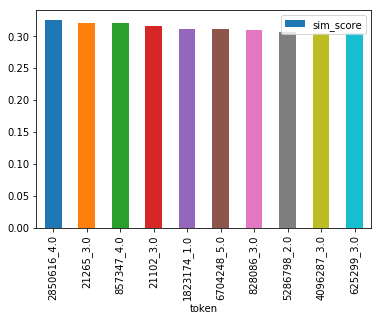

In [80]:
# Ploting similarity score
ax = results[['token','sim_score']].plot.bar(x='token', y='sim_score')
plt.show()

In [81]:
# Using Tf-idf to compare similarities
from sklearn.feature_extraction.text import TfidfVectorizer
documents=[]
documents = results['reviewText'].tolist()
documents.append ( Amazon_Book_Review)
tfidf = TfidfVectorizer(min_df=1).fit_transform(documents)
# no need to normalize, since Vectorizer will return normalized tf-idf
tf_results=tfidf * tfidf.T
tf_results=tf_results.toarray()
tf_results=tf_results[:10,10]


[0.3649134  0.42278339 0.37267677 0.2282962  0.15793806 0.2929269
 0.32769875 0.22979589 0.19415259 0.31474169]


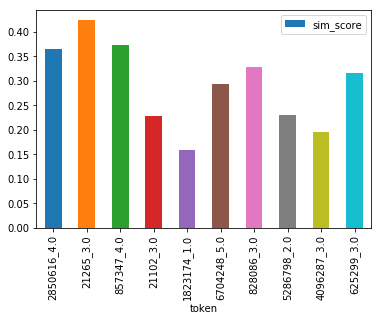

In [100]:
# Note that we ran tf-idf on the 10 similar documents suggested by the dco2vec.
# ps: doc2vec picked these 10 from 1.6 Million documents
# The results are similar , with top 3 documents being the closest
# However, it will be interesting to see this results on 1.6 Million documents
res_tf=pd.DataFrame(tf_results,results['token']).reset_index()
res_tf=res_tf.rename(columns={0:'sim_score'})
ax = res_tf.plot.bar(x='token', y='sim_score')
plt.show()